# Question 1

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm

In [13]:
np.random.seed(42)
torch.manual_seed(42)

# Define the parameters of the bivariate distribution
mu1 = torch.tensor([0, 0], dtype=torch.float32)
mu2 = torch.tensor([2, 2], dtype=torch.float32)
mu3 = torch.tensor([-2, 2], dtype=torch.float32)
sigma = 2

# Generate 10,000 samples from the bivariate distribution
samples = np.concatenate([
    np.random.multivariate_normal(mu1, sigma * np.eye(2), 3333),
    np.random.multivariate_normal(mu2, sigma * np.eye(2), 3333),
    np.random.multivariate_normal(mu3, sigma * np.eye(2), 3334)])

In [14]:
# Generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, z):
        return self.model(z)

In [15]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [16]:
# Initializing generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)


In [17]:
# Training Loop
num_epochs = 10000
batch_size = 64

# Lists to store discriminator and generator losses for each epoch
d_losses = []
g_losses = []

for epoch in tqdm(range(num_epochs)):
    # Generate random noise samples
    z = Variable(torch.randn(batch_size, 2))

    # Generate fake samples using generator
    fake_samples = generator(z)

    # Generate real samples from true distribution
    real_samples = Variable(torch.tensor(samples[np.random.choice(10000, batch_size)], dtype=torch.float32))

    # Training discriminator
    optimizer_D.zero_grad()

    # Discriminator loss for real samples
    real_labels = Variable(torch.ones(batch_size, 1))
    real_loss = criterion(discriminator(real_samples), real_labels)

    # Discriminator loss for fake samples
    fake_labels = Variable(torch.zeros(batch_size, 1))
    fake_loss = criterion(discriminator(fake_samples.detach()), fake_labels)

    # Total discriminator loss
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_D.step()

    # Training generator
    optimizer_G.zero_grad()
    fake_labels = Variable(torch.ones(batch_size, 1))

    # Generator loss
    g_loss = criterion(discriminator(fake_samples), fake_labels)
    g_loss.backward()
    optimizer_G.step()
    
    # Append discriminator and generator losses for plotting graph
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

100%|██████████| 10000/10000 [00:05<00:00, 1753.89it/s]


In [18]:
# Generate points from trained GAN
num_generated_points = 10000
generated_points = generator(Variable(torch.randn(num_generated_points, 2))).detach().numpy()
print("Generated Points")

Generated Points


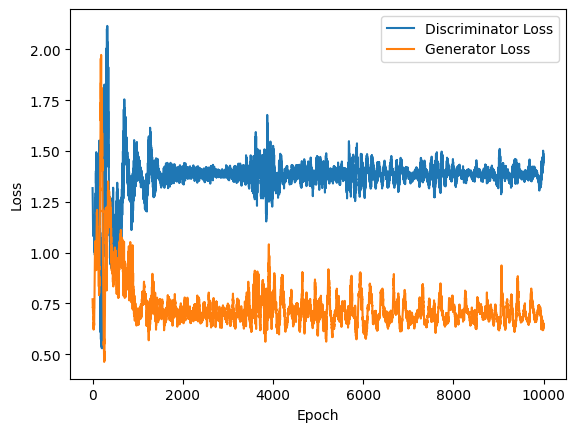

In [19]:
# Plot the Loss vs Epoch curve
plt.plot(range(num_epochs), d_losses, label="Discriminator Loss")
plt.plot(range(num_epochs), g_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

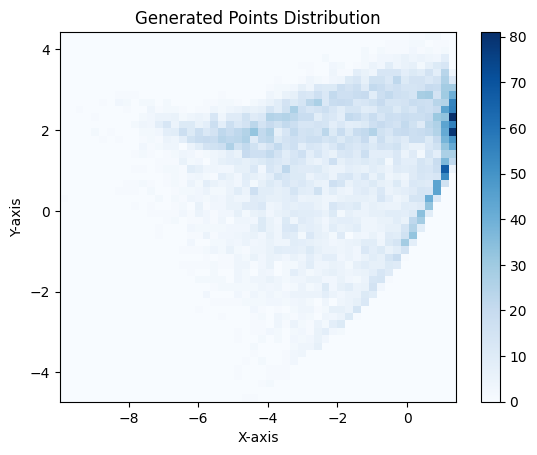

In [20]:
# Generate histogram plot of the generated points
plt.hist2d(generated_points[:, 0], generated_points[:, 1], bins=50, cmap='Blues')
plt.title("Generated Points Distribution")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.colorbar()
plt.show()

# Question 2:

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from inception_score import inception_score # from folder

In [24]:
torch.manual_seed(42)
if torch.backends.mps.is_available():
    device = torch.device("mps")
print("Device:", device)

Device: mps


In [25]:
# Define the generator and discriminator architectures
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        print("Ended Generator Code")

    def forward(self, input):
        return self.model(input)

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        print("Ended Discriminator Code")

    def forward(self, input):
        return self.model(input)

In [27]:
# Initialize the generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Define the loss function and optimizers
criterion = nn.BCELoss().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Set up DataLoader for CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 64
dataset = datasets.CIFAR10(root='./data', download=True, train=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

Ended Generator Code
Ended Discriminator Code
Files already downloaded and verified


In [28]:
# Training the DCGAN
num_epochs = 5
generator.to(device)
discriminator.to(device)

# Lists to store the discriminator and generator loss for each epoch
discriminator_losses = []
generator_losses = []

for epoch in tqdm(range(num_epochs)):
    for i, data in enumerate(dataloader, 0):
        # Update discriminator with real data
        discriminator.zero_grad()
        real_images, _ = data
        real_images = real_images.to(device)
        batch_size_curr = real_images.size(0)  # Get the current batch size
        label = torch.full((batch_size_curr, 1, 1, 1), 1.0, device=device)
        output = discriminator(real_images)
        # errD_real = criterion(output, label)
        errD_real = criterion(output, label.expand_as(output))
        errD_real.backward()
        D_x = output.mean().item()
        print("Worked real output", i , "Times")
        
        # Update discriminator with fake data
        noise = torch.randn(batch_size_curr, 100, 1, 1, device=device) 
        fake_images = generator(noise)
        label.fill_(0.0)
        output = discriminator(fake_images.detach())
        errD_fake = criterion(output, label.expand_as(output))
        print("errD_fake Criterion worked ", i , "times")
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizer_D.step()

        # Update generator
        generator.zero_grad()
        label.fill_(1.0)
        output = discriminator(fake_images)
        # print("Discriminator: ")
        errG = criterion(output, label.expand_as(output))
        # print("errG:")
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizer_G.step()
        
    # Append the discriminator and generator loss for the current epoch
    discriminator_losses.append(errD.item())
    generator_losses.append(errG.item())
print("Train loop ended")     
  
# Save the generator model
torch.save(generator.state_dict(), 'generatorr.pth')

  0%|          | 0/5 [00:00<?, ?it/s]

Worked real output 0 Times
errD_fake Criterion worked  0 times
Worked real output 1 Times
errD_fake Criterion worked  1 times
Worked real output 2 Times
errD_fake Criterion worked  2 times
Worked real output 3 Times
errD_fake Criterion worked  3 times
Worked real output 4 Times
errD_fake Criterion worked  4 times
Worked real output 5 Times
errD_fake Criterion worked  5 times
Worked real output 6 Times
errD_fake Criterion worked  6 times
Worked real output 7 Times
errD_fake Criterion worked  7 times
Worked real output 8 Times
errD_fake Criterion worked  8 times
Worked real output 9 Times
errD_fake Criterion worked  9 times
Worked real output 10 Times
errD_fake Criterion worked  10 times
Worked real output 11 Times
errD_fake Criterion worked  11 times
Worked real output 12 Times
errD_fake Criterion worked  12 times
Worked real output 13 Times
errD_fake Criterion worked  13 times
Worked real output 14 Times
errD_fake Criterion worked  14 times
Worked real output 15 Times
errD_fake Criteri

 20%|██        | 1/5 [05:30<22:03, 330.92s/it]

Worked real output 0 Times
errD_fake Criterion worked  0 times
Worked real output 1 Times
errD_fake Criterion worked  1 times
Worked real output 2 Times
errD_fake Criterion worked  2 times
Worked real output 3 Times
errD_fake Criterion worked  3 times
Worked real output 4 Times
errD_fake Criterion worked  4 times
Worked real output 5 Times
errD_fake Criterion worked  5 times
Worked real output 6 Times
errD_fake Criterion worked  6 times
Worked real output 7 Times
errD_fake Criterion worked  7 times
Worked real output 8 Times
errD_fake Criterion worked  8 times
Worked real output 9 Times
errD_fake Criterion worked  9 times
Worked real output 10 Times
errD_fake Criterion worked  10 times
Worked real output 11 Times
errD_fake Criterion worked  11 times
Worked real output 12 Times
errD_fake Criterion worked  12 times
Worked real output 13 Times
errD_fake Criterion worked  13 times
Worked real output 14 Times
errD_fake Criterion worked  14 times
Worked real output 15 Times
errD_fake Criteri

 40%|████      | 2/5 [11:19<17:04, 341.55s/it]

Worked real output 0 Times
errD_fake Criterion worked  0 times
Worked real output 1 Times
errD_fake Criterion worked  1 times
Worked real output 2 Times
errD_fake Criterion worked  2 times
Worked real output 3 Times
errD_fake Criterion worked  3 times
Worked real output 4 Times
errD_fake Criterion worked  4 times
Worked real output 5 Times
errD_fake Criterion worked  5 times
Worked real output 6 Times
errD_fake Criterion worked  6 times
Worked real output 7 Times
errD_fake Criterion worked  7 times
Worked real output 8 Times
errD_fake Criterion worked  8 times
Worked real output 9 Times
errD_fake Criterion worked  9 times
Worked real output 10 Times
errD_fake Criterion worked  10 times
Worked real output 11 Times
errD_fake Criterion worked  11 times
Worked real output 12 Times
errD_fake Criterion worked  12 times
Worked real output 13 Times
errD_fake Criterion worked  13 times
Worked real output 14 Times
errD_fake Criterion worked  14 times
Worked real output 15 Times
errD_fake Criteri

 60%|██████    | 3/5 [17:42<12:00, 360.36s/it]

Worked real output 0 Times
errD_fake Criterion worked  0 times
Worked real output 1 Times
errD_fake Criterion worked  1 times
Worked real output 2 Times
errD_fake Criterion worked  2 times
Worked real output 3 Times
errD_fake Criterion worked  3 times
Worked real output 4 Times
errD_fake Criterion worked  4 times
Worked real output 5 Times
errD_fake Criterion worked  5 times
Worked real output 6 Times
errD_fake Criterion worked  6 times
Worked real output 7 Times
errD_fake Criterion worked  7 times
Worked real output 8 Times
errD_fake Criterion worked  8 times
Worked real output 9 Times
errD_fake Criterion worked  9 times
Worked real output 10 Times
errD_fake Criterion worked  10 times
Worked real output 11 Times
errD_fake Criterion worked  11 times
Worked real output 12 Times
errD_fake Criterion worked  12 times
Worked real output 13 Times
errD_fake Criterion worked  13 times
Worked real output 14 Times
errD_fake Criterion worked  14 times
Worked real output 15 Times
errD_fake Criteri

 80%|████████  | 4/5 [24:20<06:14, 374.96s/it]

Worked real output 0 Times
errD_fake Criterion worked  0 times
Worked real output 1 Times
errD_fake Criterion worked  1 times
Worked real output 2 Times
errD_fake Criterion worked  2 times
Worked real output 3 Times
errD_fake Criterion worked  3 times
Worked real output 4 Times
errD_fake Criterion worked  4 times
Worked real output 5 Times
errD_fake Criterion worked  5 times
Worked real output 6 Times
errD_fake Criterion worked  6 times
Worked real output 7 Times
errD_fake Criterion worked  7 times
Worked real output 8 Times
errD_fake Criterion worked  8 times
Worked real output 9 Times
errD_fake Criterion worked  9 times
Worked real output 10 Times
errD_fake Criterion worked  10 times
Worked real output 11 Times
errD_fake Criterion worked  11 times
Worked real output 12 Times
errD_fake Criterion worked  12 times
Worked real output 13 Times
errD_fake Criterion worked  13 times
Worked real output 14 Times
errD_fake Criterion worked  14 times
Worked real output 15 Times
errD_fake Criteri

100%|██████████| 5/5 [31:03<00:00, 372.71s/it]

Train loop ended


In [29]:
# Generate 10 images from the learned distribution and save them
generator.eval()
for i in range(10):
    noise = torch.randn(1, 100, 1, 1, device=device)
    fake_image = generator(noise).detach().cpu().squeeze().numpy()
    fake_image = (fake_image + 1) / 2.0  # Rescale values to [0, 1]
    plt.imsave(f'generated_image_{i+1}.png', np.transpose(fake_image, (1, 2, 0)))

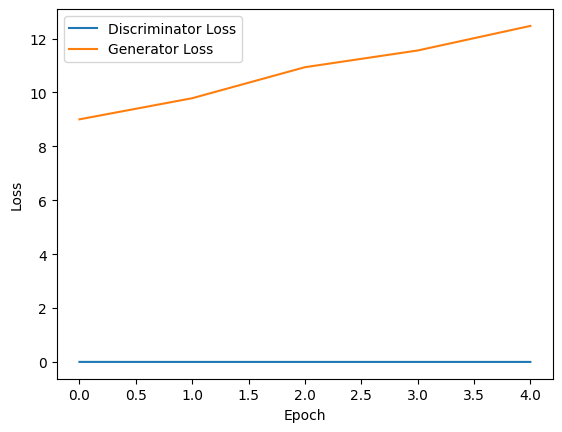

In [31]:
# Plot the Loss vs Epoch curve
plt.plot(range(num_epochs), discriminator_losses, label="Discriminator Loss")
plt.plot(range(num_epochs), generator_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [30]:
# Calculate Inception Score on the generated images
fake_images_list = []
for i in range(500):  # Generate 500 images for a more accurate Inception Score
    noise = torch.randn(1, 100, 1, 1, device=device)
    fake_images_list.append(generator(noise).detach().cpu())
fake_images_tensor = torch.cat(fake_images_list, dim=0)
inception_mean, inception_std = inception_score(fake_images_tensor, 
                                                cuda=False, #cuda=True, 
                                                batch_size=32, resize=True, splits=1)

print(f"Inception Score: {inception_mean} ± {inception_std}")

Inception Score: 1.2520819672674979 ± 0.0


Inception Score: 
- for 1 epoch = 1.1946327017802276 ± 0.0
    - time taken for one loop: 06:40 & 400.02s/it
- for 5 epochs =  1.2520819672674979 ± 0.0
    - time taken: 33:11